# Table of Contents

 - [Text Processing and EDA of the Test Dataset](#Text-Processing-and-EDA-of-the-Test-Dataset) 
 <br>
 
      - [Load and Explore the Data](#Load-and-Explore-the-Data)
           - [Number of comments under each category](#Number-of-comments-under-each-category)
           - [Correlation between categories](#Correlation-between-categories)
           - [Word and character count](#Word-and-character-count)
           - [Word Cloud](#Word-Cloud)
      - [Text Cleaning and Preprocessing](#Text-Cleaning-and-Preprocessing)
           - [Word Cloud Representation After Text Preprocessing](#Word-Cloud-Representation-After-Text-Preprocessing)
      - [EDA Based on Two Non-toxic and Toxic Groups](#EDA-Based-on-Two-Non-toxic-and-Toxic-Groups)
      - [Save the Data](#Save-the-Data)


# Text Processing and EDA of the Test Dataset

The objective of this notebook is to explore the corpus, clear the text and perform the EDA on the test dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import collections
import nltk
import seaborn as sns
import re
import textblob
import spacy
from nltk.tokenize.toktok import ToktokTokenizer
from collections import Counter

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 150)
pd.set_option('display.notebook_repr_html', True)

sns.set_context('talk', rc={"grid.linewidth": 0.8})

%matplotlib inline

## Load and Explore the Data

In [2]:
# Read data
test = pd.read_csv('Library/test_df.csv')

In [3]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beck...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a type. The """"Type"""" of institution is needed in this case because there are three levels of SUNY schools...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the list, make sure it's relevant == \n\n Before adding a new product to the list, make sure it has a wik...",0,0,0,0,0,0


### Number of comments under each category

First, let's figure out the number of rows under each category of toxicity. From now on, the non-toxic comments are called "clean comments".

In [4]:
df1 = test.iloc[:, 2:].sum(axis=1)
total_comments = len(df1)
clean_comments = len(df1[df1==0])
tagged_comments = len(df1[df1!=0])

print('Total comments:{}'.format(total_comments))
print('Clean comments:{}'.format(clean_comments))
print('Tagged comments:{}'.format(tagged_comments))

Total comments:63978
Clean comments:57735
Tagged comments:6243


I plot the histogram of the number of comments under each category.

In [5]:
df1 = test[test.columns[2:]].melt()
df1 = df1[df1.value == 1]
df1.head()

,variable,value
8,toxic,1
24,toxic,1
29,toxic,1
38,toxic,1
40,toxic,1


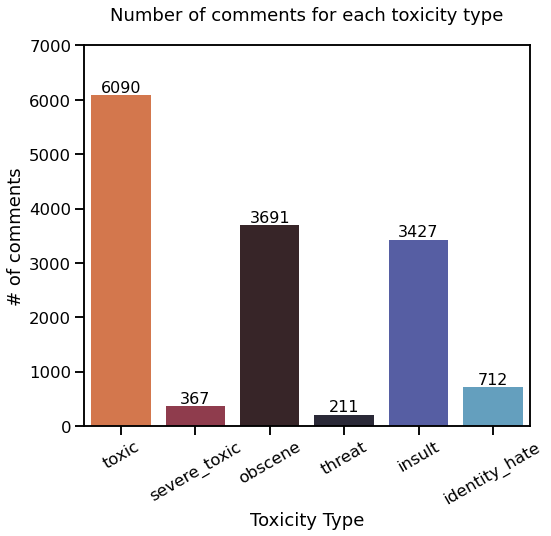

In [6]:
plt.figure(figsize=(8,7))
ax = sns.countplot(x='variable', data=df1, palette='icefire_r')
ax.set(xlabel='Toxicity Type')
ax.set(ylabel='# of comments')
ax.tick_params(axis='x', rotation=30)
plt.title('Number of comments for each toxicity type', y=1.05)
plt.ylim(0,7000)

for i in ax.containers:
    ax.bar_label(i,fontsize=16)
    
plt.show()

The toxicity is not evenly spread out across classes. Therefore, we may face class imbalance problem.
There are 16225 tagged comments in total. While, toxic category only consists of 15294 comments. Obscene and insult categories consist of more than 16000 comments together. Therefore, a comment can be classified as several types.

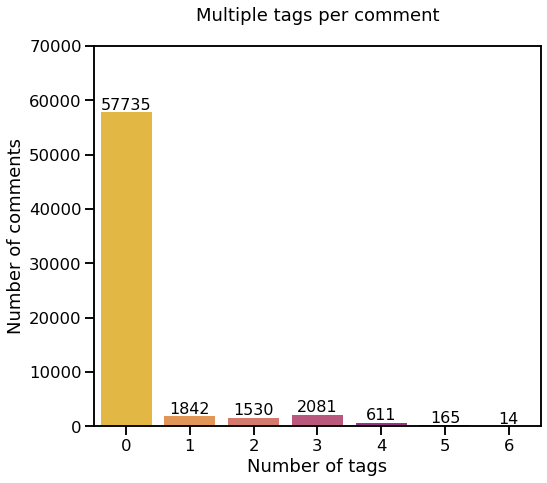

In [7]:
df1 = pd.DataFrame(test.iloc[:, 2:].sum(axis=1))
df1.columns = ['sum']

plt.figure(figsize=(8,7))
ax = sns.countplot(x='sum', data=df1, palette='plasma_r')
ax.set(xlabel='Number of tags')
ax.set(ylabel='Number of comments')
plt.title('Multiple tags per comment', y=1.05)
plt.ylim(0,70000)

for i in ax.containers:
    ax.bar_label(i,fontsize=16)
    
plt.show()

### Correlation between categories

Is there any correlation between the toxic categories?

In [8]:
df = test.iloc[:,2:]
corr = df.corr()
corr

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.234181,0.748014,0.171775,0.713363,0.317424
severe_toxic,0.234181,1.000000,0.303427,0.161685,0.285268,0.258284
obscene,0.748014,0.303427,1.000000,0.147123,0.753652,0.317549
threat,0.171775,0.161685,0.147123,1.000000,0.153406,0.116039
insult,0.713363,0.285268,0.753652,0.153406,1.000000,0.373130
identity_hate,0.317424,0.258284,0.317549,0.116039,0.373130,1.000000


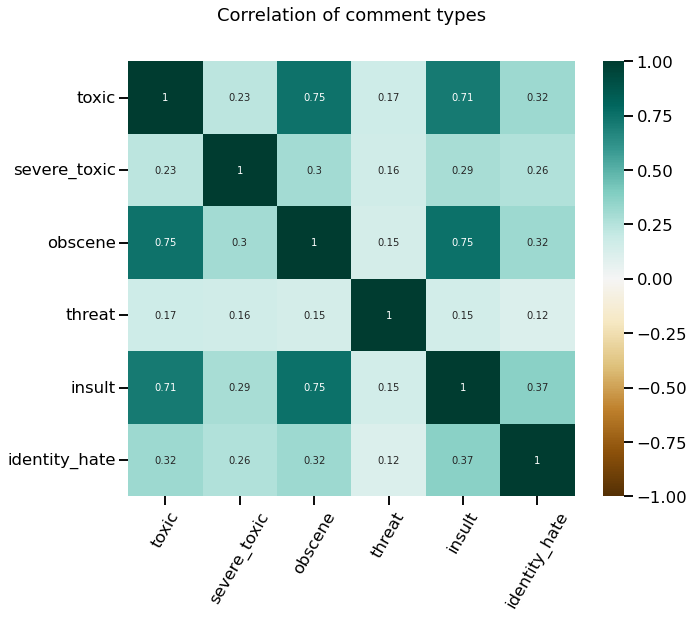

In [9]:
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.tick_params(axis='y', rotation=0)
heatmap.tick_params(axis='x', rotation=60)
heatmap.set_title('Correlation of comment types', fontdict={'fontsize':18}, y=1.08)
plt.show()

Threat category has the least correlation with the categories. While insult, obscene and toxic show the highest positive correlation with the other categories. The highest correlation is between obscene and insult.

### Word and character count

In this step, I count the number of tags, number of characters, words and sentences for each comment. Also, number of words and characters per sentences are calculated and added to the dataframe. There might be a pattern in these features.

In [10]:
test.head()

test_df = test
test_df['num_tags'] = test_df.iloc[:, 2:].sum(axis=1) 
test_df['word_count'] = test_df['comment_text'].apply(lambda x: len(nltk.word_tokenize(x)))
test_df['char_count'] = test_df['comment_text'].apply(lambda x: len(x.replace(' ', '')))
test_df['sent_count'] = test_df['comment_text'].apply(lambda x: len(nltk.sent_tokenize(x)))
test_df['avg_char_word'] = test_df['char_count'] / test_df['word_count']
test_df['avg_char_sent'] = test_df['char_count'] / test_df['sent_count']
test_df['avg_word_sent'] = test_df['word_count'] / test_df['sent_count']
test_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,num_tags,word_count,char_count,sent_count,avg_char_word,avg_char_sent,avg_word_sent
0,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0,0,18,81,2,4.500000,40.500000,9.000000
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,0,8,27,1,3.375000,27.000000,8.000000
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beck...",0,0,0,0,0,0,0,93,371,6,3.989247,61.833333,15.500000
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a type. The """"Type"""" of institution is needed in this case because there are three levels of SUNY schools...",0,0,0,0,0,0,0,100,412,5,4.120000,82.400000,20.000000
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the list, make sure it's relevant == \n\n Before adding a new product to the list, make sure it has a wik...",0,0,0,0,0,0,0,71,275,3,3.873239,91.666667,23.666667


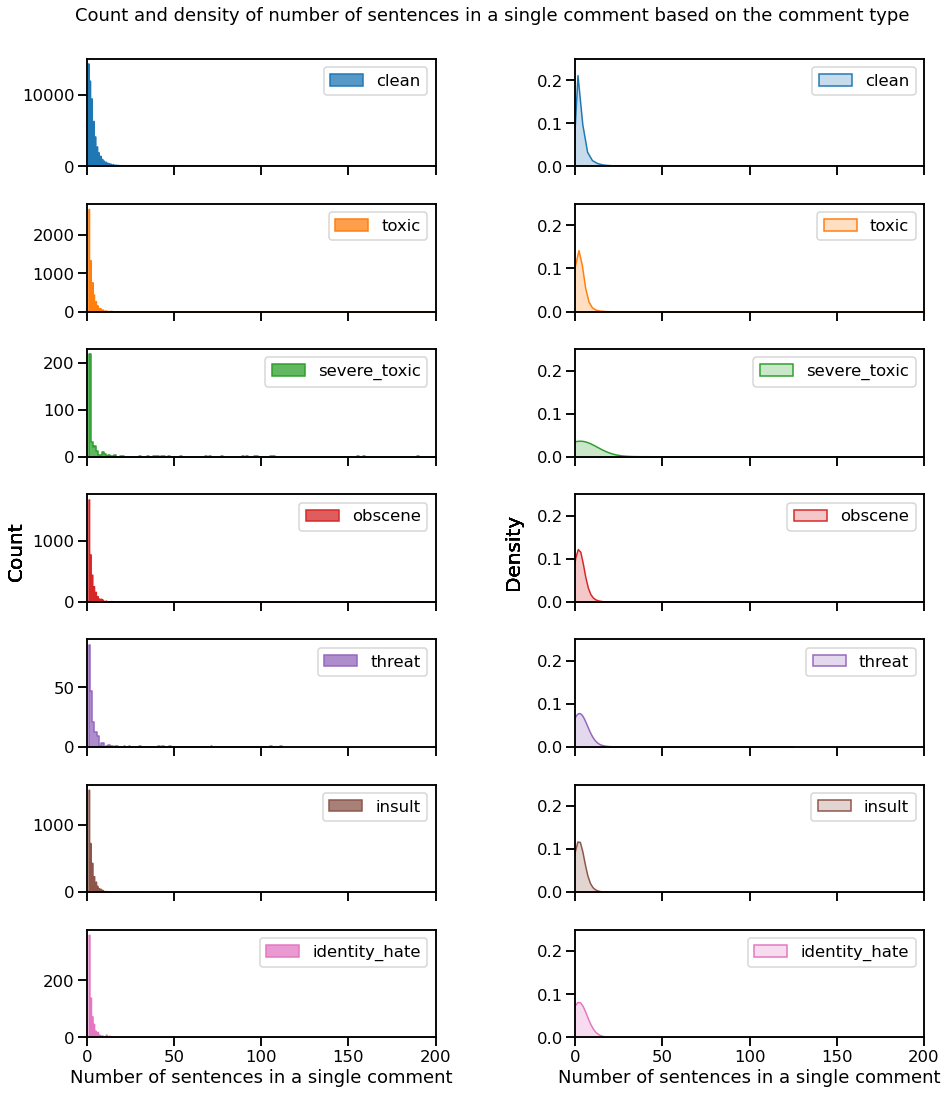

In [11]:
title = 'Count and density of number of sentences in a single comment based on the comment type'

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,18), sharex=True)
plt.subplots_adjust(hspace=0.35, wspace=0.4)
fig.suptitle(title, fontsize=18, y=0.92)
colors = sns.color_palette("tab10", 7)

sns.histplot(data=test_df[test_df['num_tags']==0], x='sent_count', color=colors[0], 
             label='clean', element='step', ax=ax[0,0])

sns.kdeplot(data=test_df[test_df['num_tags']==0]['sent_count'], color=colors[0], 
            ax=ax[0,1], label='clean', shade=True)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_xlim(0,200)
ax[0, 1].set_ylim(0,0.25)
ax[0, 0].set(ylabel=None)
ax[0, 1].set(ylabel=None)

row_count = 1

for col in test_df.columns[2:8]:
    
    sns.histplot(data=test_df[test_df[col]==1], x='sent_count', color=colors[row_count], 
             label=col, element='step', ax=ax[row_count,0])
    
    sns.kdeplot(data=test_df[test_df[col]==1]['sent_count'], color=colors[row_count], 
                 ax=ax[row_count,1], label=col, shade=True)
    
    ax[row_count, 0].legend()
    ax[row_count, 1].legend()
    ax[row_count, 0].set_xlim(0,200)
    ax[row_count, 1].set_ylim(0,0.25)
    ax[row_count, 0].set_xlabel('Number of sentences in a single comment')
    ax[row_count, 1].set_xlabel('Number of sentences in a single comment')
    ax[row_count, 0].set(ylabel=None)
    ax[row_count, 1].set(ylabel=None)
    fig.text(0.06, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)
    fig.text(0.52, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=20)    
    
    row_count += 1

The non-toxic comments tend to contain less number sentences compared to the toxic comments. Severe toxic and threat comments tend to include more number of sentences.

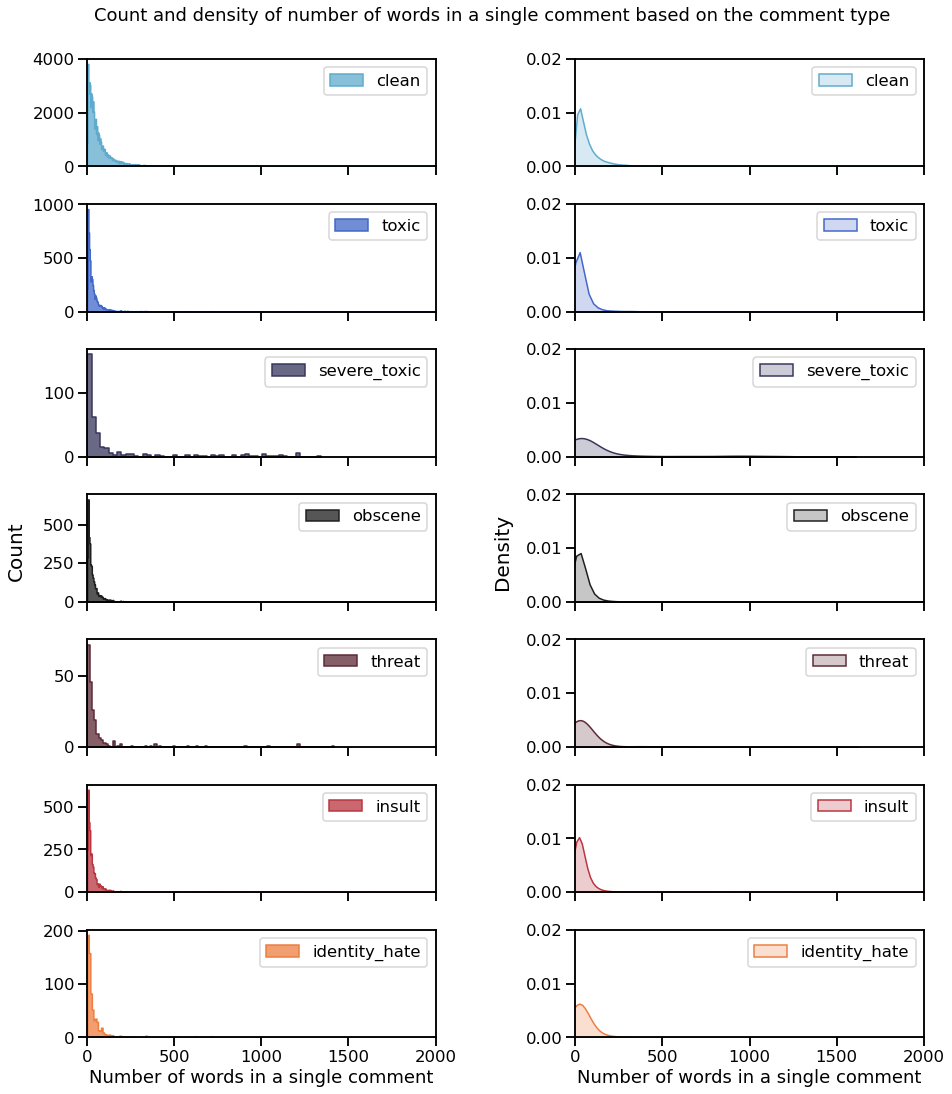

In [12]:
title = 'Count and density of number of words in a single comment based on the comment type'
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,18), sharex=True)
plt.subplots_adjust(hspace=0.35, wspace=0.4)
fig.suptitle(title, fontsize=18, y=0.92)
colors = sns.color_palette("icefire", 7)

sns.histplot(data=test_df[test_df['num_tags']==0], x='word_count', color=colors[0], 
             label='clean', element='step', ax=ax[0,0])

sns.kdeplot(data=test_df[test_df['num_tags']==0]['word_count'], color=colors[0], 
            ax=ax[0,1], label='clean', shade=True)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_xlim(0,2000)
ax[0, 1].set_ylim(0,0.02)
ax[0, 0].set(ylabel=None)
ax[0, 1].set(ylabel=None)

row_count = 1

for col in test_df.columns[2:8]:
    
    sns.histplot(data=test_df[test_df[col]==1], x='word_count', color=colors[row_count], 
             label=col, element='step', ax=ax[row_count,0])
    
    sns.kdeplot(data=test_df[test_df[col]==1]['word_count'], color=colors[row_count], 
                 ax=ax[row_count,1], label=col, shade=True)
    
    ax[row_count, 0].legend()
    ax[row_count, 1].legend()
    ax[row_count, 0].set_xlim(0,2000)
    ax[row_count, 1].set_ylim(0,0.02)
    ax[row_count, 0].set_xlabel('Number of words in a single comment')
    ax[row_count, 1].set_xlabel('Number of words in a single comment')
    ax[row_count, 0].set(ylabel=None)
    ax[row_count, 1].set(ylabel=None)
    
    row_count += 1   
fig.text(0.06, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.51, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=20) 
plt.show()

Severe toxic and threat comment types tend to include greater number of words compared to non-toxic and other toxic categories.

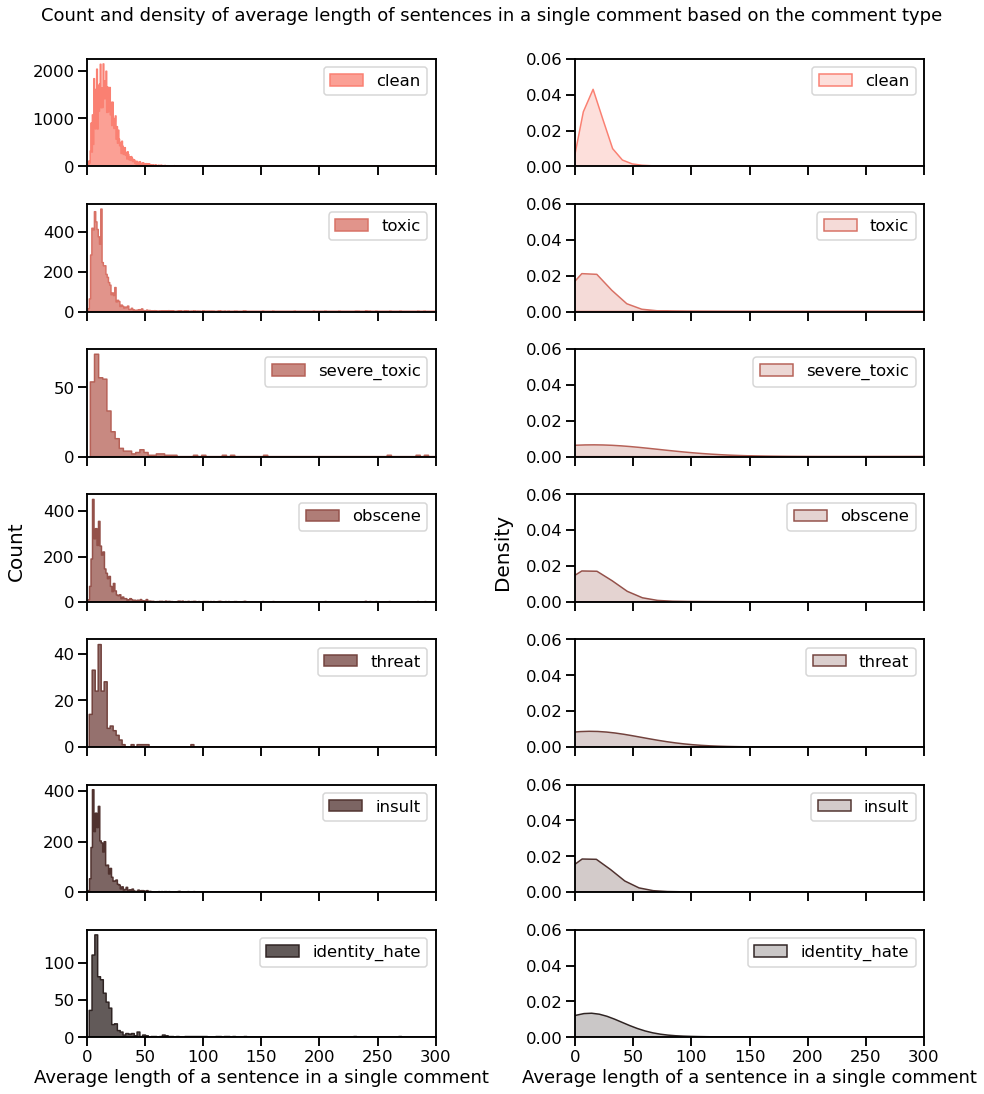

In [13]:
title = 'Count and density of average length of sentences in a single comment based on the comment type'

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,18), sharex=True)
fig.suptitle(title, fontsize=18, y=0.92)
fig.subplots_adjust(hspace=0.35, wspace=0.4)
colors = sns.color_palette("dark:salmon_r", 7)

sns.histplot(data=test_df[test_df['num_tags']==0], x='avg_word_sent', color=colors[0], 
             label='clean', element='step', ax=ax[0,0])

sns.kdeplot(data=test_df[test_df['num_tags']==0]['avg_word_sent'], color=colors[0], 
            ax=ax[0,1], label='clean', shade=True)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_xlim(0,300)
ax[0, 1].set_ylim(0,0.06)
ax[0, 0].set(ylabel=None)
ax[0, 1].set(ylabel=None)

row_count = 1

for col in test_df.columns[2:8]:
    
    sns.histplot(data=test_df[test_df[col]==1], x='avg_word_sent', color=colors[row_count], 
             label=col, element='step', ax=ax[row_count,0])
    
    sns.kdeplot(data=test_df[test_df[col]==1]['avg_word_sent'], color=colors[row_count], 
                 ax=ax[row_count,1], label=col, shade=True)
    
    ax[row_count, 0].legend()
    ax[row_count, 1].legend()
    ax[row_count, 0].set_xlim(0,300)
    ax[row_count, 1].set_ylim(0,0.06)
    ax[row_count, 0].set_xlabel('Average length of a sentence in a single comment')
    ax[row_count, 1].set_xlabel('Average length of a sentence in a single comment')
    ax[row_count, 0].set(ylabel=None)
    ax[row_count, 1].set(ylabel=None)
    
    row_count += 1
    
fig.text(0.06, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.51, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=20) 
plt.show()

In general, average length of a sentence in toxic categories is longer than the non-toxic comments. Specifically, severe toxic, identity hate and threat sentences are longer than the other categories.

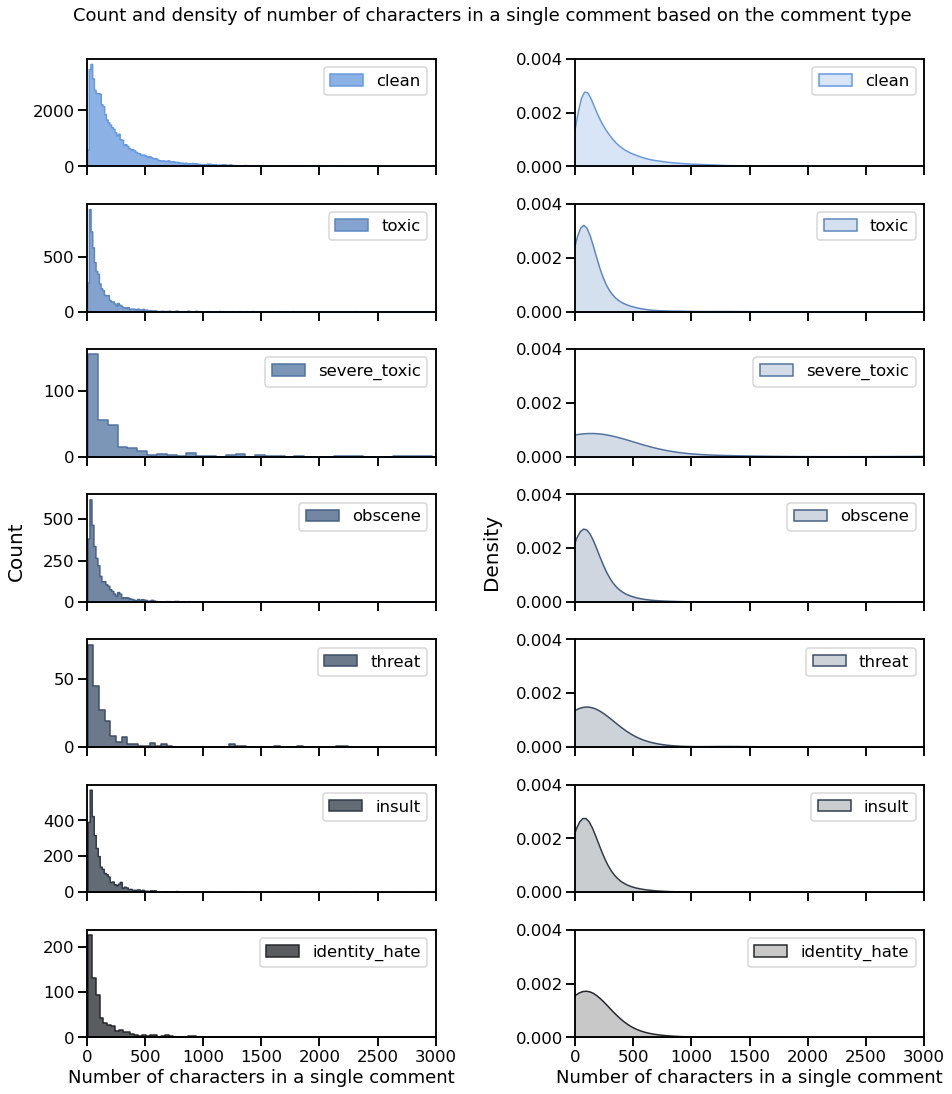

In [14]:
title = 'Count and density of number of characters in a single comment based on the comment type'

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,18), sharex=True)
fig.suptitle(title, fontsize=18, y=0.92)
fig.subplots_adjust(hspace=0.35, wspace=0.4)
colors = sns.dark_palette("#69d", 7, reverse=True)

sns.histplot(data=test_df[test_df['num_tags']==0], x='char_count', color=colors[0], 
             label='clean', element='step', ax=ax[0,0])

sns.kdeplot(data=test_df[test_df['num_tags']==0]['char_count'], color=colors[0], 
            ax=ax[0,1], label='clean', shade=True)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_xlim(0,3000)
ax[0, 1].set_ylim(0,0.004)
ax[0, 0].set(ylabel=None)
ax[0, 1].set(ylabel=None)

row_count = 1

for col in test_df.columns[2:8]:
    
    sns.histplot(data=test_df[test_df[col]==1], x='char_count', color=colors[row_count], 
             label=col, element='step', ax=ax[row_count,0])
    
    sns.kdeplot(data=test_df[test_df[col]==1]['char_count'], color=colors[row_count], 
                 ax=ax[row_count,1], label=col, shade=True)
    
    ax[row_count, 0].legend()
    ax[row_count, 1].legend()
    ax[row_count, 0].set_xlim(0,3000)
    ax[row_count, 1].set_ylim(0,0.004)
    ax[row_count, 0].set_xlabel('Number of characters in a single comment')
    ax[row_count, 1].set_xlabel('Number of characters in a single comment')
    ax[row_count, 0].set(ylabel=None)
    ax[row_count, 1].set(ylabel=None)
    
    row_count += 1
    
fig.text(0.06, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=20) 

plt.show()

Nnumber of characters of a sentence in tidentity hate, threat and severe toxic categories tend to be larger compared to non-toxic and other toxic categories.

I am curious to know if there is any correlation between the number of tags and word and sentence counts! Let's figure it out.

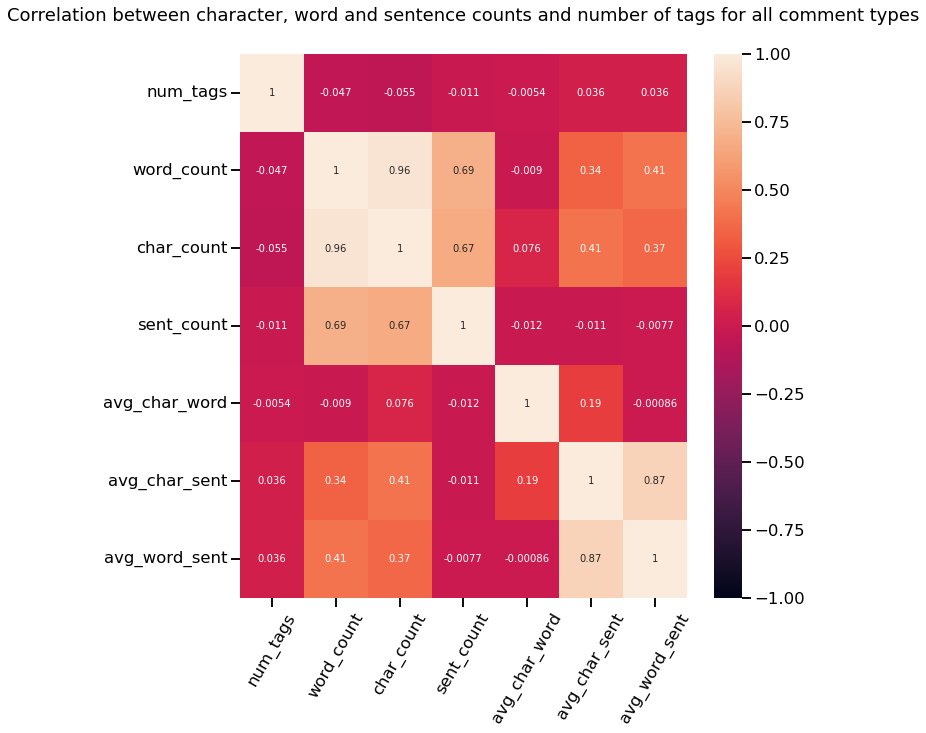

In [15]:
corr = test_df.iloc[:, -7:].corr()
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.tick_params(axis='y', rotation=0)
heatmap.tick_params(axis='x', rotation=60)
heatmap.set_title('Correlation between character, word and sentence counts and number of tags for all comment types'
                  , y =1.05)
plt.show()

There is no correlation between the number of tags and the other features!

### Word Cloud

Now, I visualize the the text information for each category. A nice way to visualize the text information is using a word cloud.

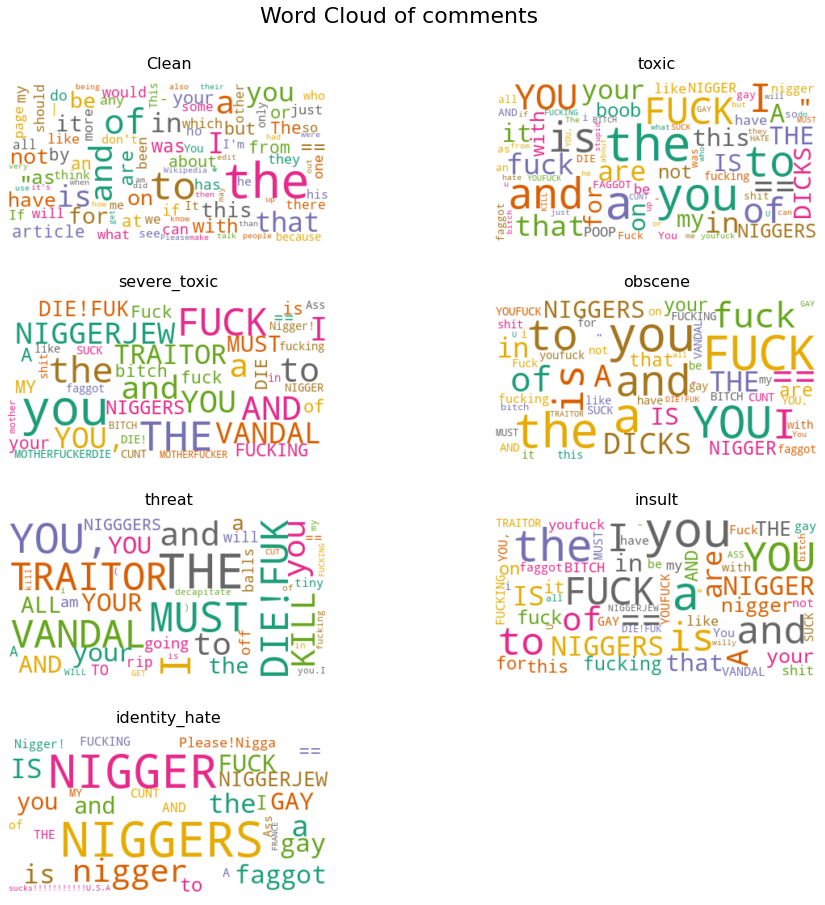

In [16]:
cloud = WordCloud(max_font_size=60, min_font_size=10, max_words=100, background_color='white', 
               colormap='Dark2', repeat=False, random_state=10, contour_width=0.1,
            contour_color='black',mode='RGB', collocations=False)

fig = plt.figure(figsize=(15,15))

# Non-toxic comments
text = list(' '.join(test_df[test_df.num_tags == 0]['comment_text']).split())
counter = Counter(text)
most_common = counter.most_common()

frequency = {}
for word, count in most_common[:100]:
    frequency[word] = count

wordcloud = cloud.generate_from_frequencies(frequency)
ax = fig.add_subplot(4, 2, 1)
ax.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Clean', fontsize=16, y=1.05)
  

# Toxic comments
i = 2
for col in test_df.columns[2:8]:
    
    ax = fig.add_subplot(4, 2, i)
    
    text = list(' '.join(test_df[test_df[col] != 0]['comment_text']).split())
    counter = Counter(text)
    most_common = counter.most_common()

    frequency = {}
    for word, count in most_common[:100]:
        frequency[word] = count
        
    wordcloud = cloud.generate_from_frequencies(frequency)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.title(col, fontsize=16, y=1.05)
    plt.suptitle('Word Cloud of comments', fontsize=22, y=0.95)
    i += 1
    
fig.subplots_adjust(hspace=0.35, wspace=0.4)
plt.show()

The wordcloud representation shows that I need to perform text prepocessing. I need to remove unnecessary words, like punctutation, white spaces and stop words. Also, lemmatization (converting a word to its base form) and lower casing are essential.

## Text Cleaning and Preprocessing

In this section, I define functions to perform text preprocessing and cleaning and test the functions, too.

In [17]:
# Removing special characters

def special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, ' ', text)
    return text

test['comment_text'][:5].apply(special_characters)

0                                                         Thank you for understanding  I think very highly of you and would not revert without discussion 
1                                                                                                                          Dear god this site is horrible 
2         Somebody will invariably try to add Religion   Really    You mean  the way people have invariably kept adding   Religion   to the Samuel Beck...
3      \n\n It says it right there that it IS a type  The   Type   of institution is needed in this case because there are three levels of SUNY schools...
4      \n\n    Before adding a new product to the list  make sure it s relevant    \n\n Before adding a new product to the list  make sure it has a wik...
Name: comment_text, dtype: object

In [18]:
# Lemmatization

nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

test['comment_text'][:5].apply(lemmatize_text)


/Users/zori/opt/anaconda3/lib/python3.9/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


0                                                       thank you for understanding . I think very highly of you and would not revert without discussion .
1                                                                                                                       : dear god this site be horrible .
2    " : : : somebody will invariably try to add Religion ?   really ? ?   you mean , the way people have invariably keep add " " religion " " to the S...
3    " \n\n  it say it right there that it be a type . the " " type " " of institution be need in this case because there be three level of SUNY school...
4    " \n\n  = = before add a new product to the list , make sure it be relevant = = \n\n  before add a new product to the list , make sure it have a w...
Name: comment_text, dtype: object

In [19]:
# Remove stop words

stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove('no')
stopwords.remove('not')

def remove_stopwords(text):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    text = ' '.join([token for token in tokens if token.lower() not in stopwords])
    return text

remove_stopwords(test['comment_text'][0])

'Thank understanding. think highly would not revert without discussion .'

In [20]:
# Case conversion

def text_conversion(text, case = 'lower'):
    if case == 'lower':
        return text.lower()
    elif case == 'upper':
        return text.upper()
    elif case == 'title':
        return text.title()
    else:
        return text
    
text_conversion(test['comment_text'][0], case='lower')

'thank you for understanding. i think very highly of you and would not revert without discussion.'

In [21]:
import time

starttime = time.time()

for i in range(0, len(test_df), 10000):
    comment_df = test_df[i:i+10000]
    test_df.loc[i:i+10000,['clean_text']] = comment_df['comment_text'].apply(special_characters). \
                apply(lemmatize_text).apply(remove_stopwords).apply(text_conversion)
          
    time.sleep(2)
    
print('The text preprocessing took {} seconds'.format(time.time() - starttime))

The text preprocessing took 834.8766348361969 seconds


In [22]:
test_df[['comment_text', 'clean_text']].head()

,comment_text,clean_text
0,Thank you for understanding. I think very highly of you and would not revert without discussion.,thank understand think highly would not revert without discussion
1,:Dear god this site is horrible.,dear god site horrible
2,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beck...",somebody invariably try add religion really mean way people invariably keep add religion samuel beckett infobox bother bring long dead completely ...
3,""" \n\n It says it right there that it IS a type. The """"Type"""" of institution is needed in this case because there are three levels of SUNY schools...",say right type type institution need case three level suny school university centers doctoral granting institutions state college community colleg...
4,""" \n\n == Before adding a new product to the list, make sure it's relevant == \n\n Before adding a new product to the list, make sure it has a wik...",add new product list make sure relevant add new product list make sure wikipedia entry already prove relevance give reader possibility read otherw...


In [23]:
test_df[['comment_text', 'clean_text']].tail()

,comment_text,clean_text
63973,":Jerome, I see you never got around to this…! I’m not surprised: I looked for an example of the ‘’in nomine’’ plainsong notaion and couldn’t find ...",jerome see never get around not surprised look example nomine plainsong notaion find one online astonishment maybe could clear question cantus fir...
63974,==Lucky bastard== \n http://wikimediafoundation.org/wiki/Press_releases/English_Wikipedia_Announces_Thousandth_Featured_Article \n\n Heh you are f...,lucky bastard http wikimediafoundation org wiki press release english wikipedia announce thousandth featured article heh famous kida envy congrats
63975,==shame on you all!!!== \n\n You want to speak about gays and not about romanians...,shame want speak gay not romanian
63976,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MOVIES. HE HAS SO MUCH BUTTSEX THAT HIS ASSHOLE IS NOW BIG ENOUGH TO BE CONSIDERED A COUNTRY.,mel gibson nazi bitch makes shitty movies much buttsex asshole big enough consider country
63977,""" \n\n == Unicorn lair discovery == \n\n Supposedly, a 'unicorn lair' has been discovered in Pyongyang, North Korea. The lair is supposedly associ...",unicorn lair discovery supposedly unicorn lair discover pyongyang north korea lair supposedly associate king dongmyeong goguryeo supposedly ride u...


### Word Cloud Representation After Text Preprocessing

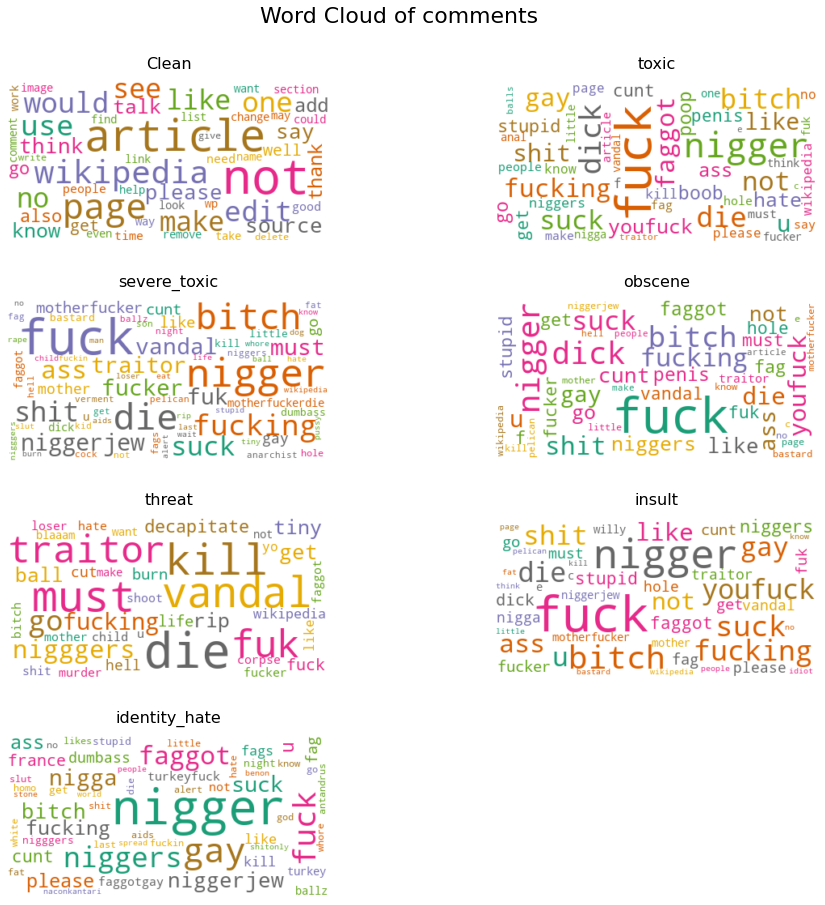

In [24]:
cloud = WordCloud(max_font_size=60, min_font_size=10, max_words=100, background_color='white', 
               colormap='Dark2', repeat=False, random_state=10, contour_width=0.1,
            contour_color='black',mode='RGB', collocations=False)

fig = plt.figure(figsize=(15,15))

# Non-toxic comments
text = list(' '.join(test_df[test_df.num_tags == 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

frequency = {}
for word, count in most_common[:100]:
    frequency[word] = count

wordcloud = cloud.generate_from_frequencies(frequency)
ax = fig.add_subplot(4, 2, 1)
ax.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Clean', fontsize=16, y=1.05)
  

# Toxic comments
i = 2
for col in test_df.columns[2:8]:
    
    ax = fig.add_subplot(4, 2, i)
    
    text = list(' '.join(test_df[test_df[col] != 0]['clean_text']).split())
    counter = Counter(text)
    most_common = counter.most_common()

    frequency = {}
    for word, count in most_common[:100]:
        frequency[word] = count
        
    wordcloud = cloud.generate_from_frequencies(frequency)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.title(col, fontsize=16, y=1.05)
    plt.suptitle('Word Cloud of comments', fontsize=22, y=0.95)
    i += 1
    
fig.subplots_adjust(hspace=0.35, wspace=0.4)
plt.show()

It seems that the text cleaning and preprocessing worked well.
<br> Now, let's look at the most common words and their counts in the text.

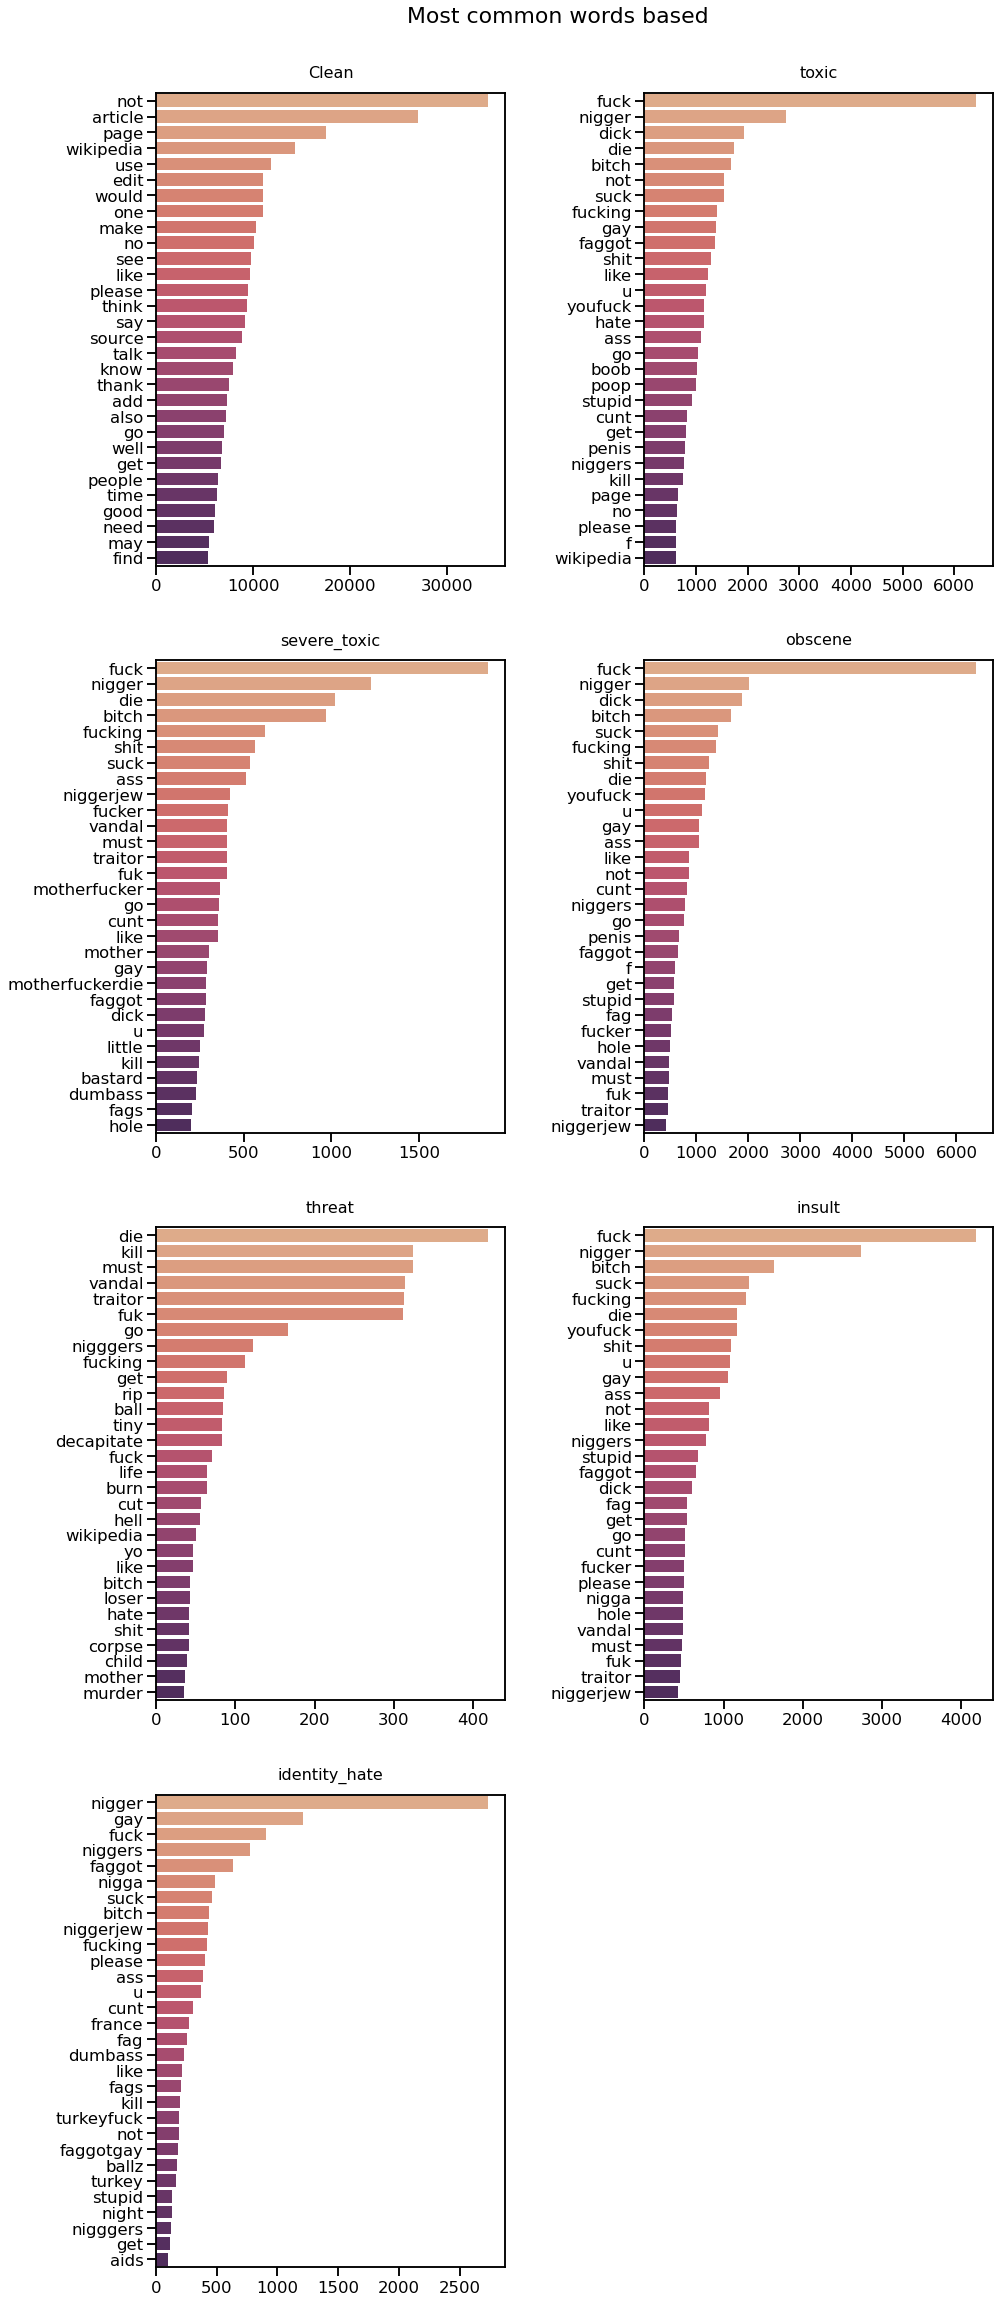

In [25]:
fig = plt.figure(figsize=(15,40))

# Non-toxic comments
text = list(' '.join(test_df[test_df.num_tags == 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

x, y = [], []
for word, count in most_common[:30]:
    y.append(word)
    x.append(count)

ax = fig.add_subplot(4, 2, 1)
sns.barplot(x=x, y=y, palette='flare')
plt.title('Clean', fontsize=16, y=1.02)
  

# Toxic comments
i = 2
for col in test_df.columns[2:8]:
    
    ax = fig.add_subplot(4, 2, i)
    
    text = list(' '.join(test_df[test_df[col] != 0]['clean_text']).split())
    counter = Counter(text)
    most_common = counter.most_common()

    x, y = [], []
    for word, count in most_common[:30]:
        y.append(word)
        x.append(count)
          
    sns.barplot(x=x, y=y, palette='flare')
    plt.title(col, fontsize=16, y=1.02)
    i += 1

plt.suptitle('Most common words based ', fontsize=22, y=0.91)
fig.subplots_adjust(hspace=0.2, wspace=0.4)
plt.show()

## EDA Based on Two Non-toxic and Toxic Groups

In the first part of this preject, I will consider only two categories for comments: non-toxic and toxic. Therefore, let's perform EDA based on only these two categories.

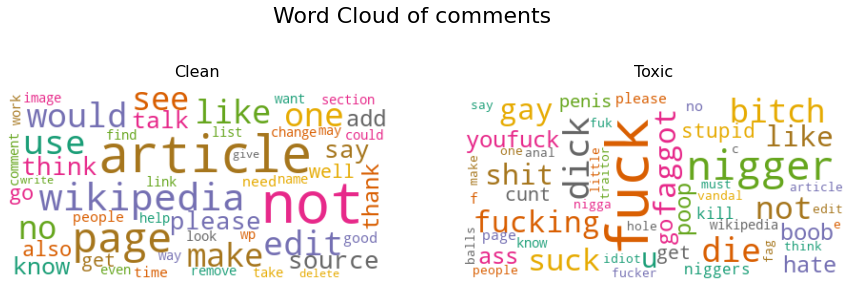

In [26]:
cloud = WordCloud(max_font_size=60, min_font_size=10, max_words=200, background_color='white', 
               colormap='Dark2', repeat=False, contour_color='black',mode='RGB', 
                collocations=False, random_state=10)

fig = plt.figure(figsize=(15,6))

# Non-toxic comments
text = list(' '.join(test_df[test_df.num_tags == 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

frequency = {}
for word, count in most_common[:100]:
    frequency[word] = count

wordcloud = cloud.generate_from_frequencies(frequency)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Clean', fontsize=16, y=1.05)
  

# Toxic comments
text = list(' '.join(test_df[test_df.num_tags != 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

frequency = {}
for word, count in most_common[:100]:
    frequency[word] = count

wordcloud = cloud.generate_from_frequencies(frequency)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Toxic', fontsize=16, y=1.05)
plt.suptitle('Word Cloud of comments', fontsize=22, y=0.92)
    
plt.show()

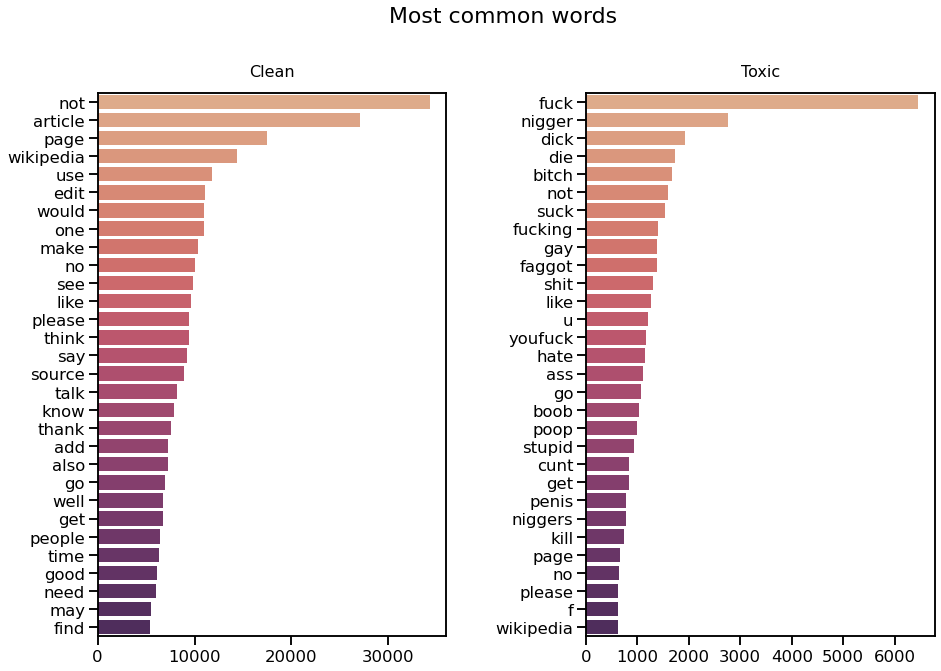

In [27]:
fig = plt.figure(figsize=(15,10))

# Non-toxic comments
text = list(' '.join(test_df[test_df.num_tags == 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

x, y = [], []
for word, count in most_common[:30]:
    y.append(word)
    x.append(count)

ax = fig.add_subplot(1, 2, 1)
sns.barplot(x=x, y=y, palette='flare')
plt.title('Clean', fontsize=16, y=1.02)
  

# Toxic comments
text = list(' '.join(test_df[test_df.num_tags != 0]['clean_text']).split())
counter = Counter(text)
most_common = counter.most_common()

x, y = [], []
for word, count in most_common[:30]:
    y.append(word)
    x.append(count)

ax = fig.add_subplot(1, 2, 2)
sns.barplot(x=x, y=y, palette='flare')
plt.title('Toxic', fontsize=16, y=1.02)
plt.suptitle('Most common words', fontsize=22, y=1)
fig.subplots_adjust(hspace=0.2, wspace=0.4)
    
plt.show()

## Save the Data

In [30]:
cleaned_test_df['toxic_type'] = np.where(cleaned_test_df.num_tags!=0, 1, 0)
cleaned_test_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,num_tags,clean_text,toxic_type
0,0001ea8717f6de06,0,0,0,0,0,0,0,thank understand think highly would not revert without discussion,0
1,000247e83dcc1211,0,0,0,0,0,0,0,dear god site horrible,0
2,0002f87b16116a7f,0,0,0,0,0,0,0,somebody invariably try add religion really mean way people invariably keep add religion samuel beckett infobox bother bring long dead completely ...,0
3,0003e1cccfd5a40a,0,0,0,0,0,0,0,say right type type institution need case three level suny school university centers doctoral granting institutions state college community colleg...,0
4,00059ace3e3e9a53,0,0,0,0,0,0,0,add new product list make sure relevant add new product list make sure wikipedia entry already prove relevance give reader possibility read otherw...,0


In [31]:
cleaned_test_df[cleaned_test_df.num_tags!=0]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,num_tags,clean_text,toxic_type
8,00091c35fa9d0465,1,0,0,0,0,0,1,arabs commit genocide iraq no protest europe may europe also burn hell,1
24,0013fed3aeae76b7,1,0,1,0,1,1,4,dj robinson gay hell suck dick much,1
29,0017d4d47894af05,1,0,1,0,1,0,3,fuck anti semitic cunt,1
38,001d739c97bc2ae4,1,0,0,0,0,0,1,dare vandalize page hms beagle vandalize demon,1
40,001eff4007dbb65b,1,0,1,0,1,0,3,no arrogant self serve immature idiot get right,1
...,...,...,...,...,...,...,...,...,...,...
63877,ff91c3d8a3e34398,1,0,0,0,1,0,2,nigel crazy idiot,1
63935,ffd49b8defd069d0,0,0,0,0,1,0,1,well feel stupid,1
63945,ffdf6854b41d9102,1,0,0,0,0,0,1,fourth baldrick possibly clever make anyone else share belief proof fourth baldrick stupidity possibly show clever small indeed,1
63962,ffebe90c8d5acaba,1,0,1,0,0,0,2,iran right iran drone spread homosexual western idea iran call bone drone get use fabulous bearded mullahs let say wording use recent iran inciden...,1


In [32]:
print(cleaned_test_df['toxic_type'].value_counts())
print(cleaned_test_df['num_tags'].value_counts())

0    57735
1     6243
Name: toxic_type, dtype: int64
0    57735
3     2081
1     1842
2     1530
4      611
5      165
6       14
Name: num_tags, dtype: int64


In [36]:
test_df = cleaned_test_df[['clean_text', 'toxic_type']]
test_df.head()

,clean_text,toxic_type
0,thank understand think highly would not revert without discussion,0
1,dear god site horrible,0
2,somebody invariably try add religion really mean way people invariably keep add religion samuel beckett infobox bother bring long dead completely ...,0
3,say right type type institution need case three level suny school university centers doctoral granting institutions state college community colleg...,0
4,add new product list make sure relevant add new product list make sure wikipedia entry already prove relevance give reader possibility read otherw...,0


In [37]:
path = '../Notebooks/Library/cleaned_text_test_df.csv'
test_df.to_csv(path, index=False)